In [ ]:
!pip install -q kaggle
!pip install opendatasets

In [ ]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images")

Skipping, found downloaded files in "./cifake-real-and-ai-generated-synthetic-images" (use force=True to force download)


#Import

In [ ]:
import os
import random as rd

# visualizations
import matplotlib.pyplot as plt
import matplotlib.image as img

# preparation and model
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam, schedules
# ResMet50
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [ ]:
AI_IMAGES =  'FAKE' # AI images folder
HM_IMAGES = 'REAL' # Man-made images folder
CLASSIFIED_FOLDER = [HM_IMAGES, AI_IMAGES]
ROOT = f'{os.getcwd()}/cifake-real-and-ai-generated-synthetic-images'
TRAIN_BASED_PATH = os.path.join(ROOT, 'train')
VALID_BASED_PATH = os.path.join(ROOT, 'test')
IMG_SIZE = (224,224)
BATCH_SIZE=64
EPOCHS=20

#EDA

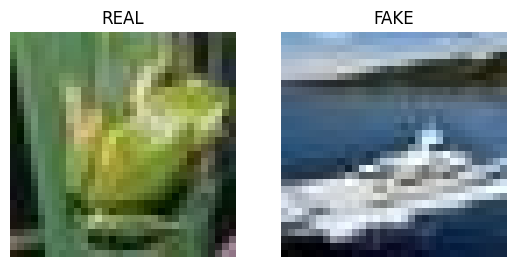

In [ ]:
def pick_sample(path_folder, classified_folder):
    fd = f'{path_folder}/{classified_folder}'
    rand_img = rd.sample(os.listdir(fd), 1)
    sample_img = img.imread(f'{fd}/{rand_img[0]}')
    return sample_img

plt.figure()

for i, item in enumerate(CLASSIFIED_FOLDER):
    plt.subplot(1, 2, i+1)
    plt.title(item)
    _img = pick_sample(TRAIN_BASED_PATH, item)
    plt.imshow(_img)
    plt.axis('off')

# Data Augmentation

In [ ]:
train_data = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.1, 0.7),
    shear_range=20,
    zoom_range=20,
    horizontal_flip=True
)

validation_data = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

train_generator = train_data.flow_from_directory(
    TRAIN_BASED_PATH,
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    target_size = IMG_SIZE
)

validation_generator = validation_data.flow_from_directory(
    VALID_BASED_PATH,
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    target_size = IMG_SIZE
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


#Model Building

In [ ]:
resnet50 = ResNet50(
    include_top=False,
    weights='imagenet', #pretrained weight
    input_tensor=None,
    input_shape=(IMG_SIZE[0],IMG_SIZE[1],3),
    pooling='avg'
)

model = Sequential()
model.add(resnet50)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                        

In [ ]:
FILEPATH = os.path.join(ROOT, 'generated-classification.keras')
def save_model(epoch, logs):
    model.save(FILEPATH, overwrite=True)


checkpoint = ModelCheckpoint(
    filepath=FILEPATH,
    monitor='val_loss',
    mode='auto',
    save_best_only=True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
h5_saver = LambdaCallback(on_epoch_end=save_model)

In [ ]:
lr_schedule = schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=10000, decay_rate=0.95)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr_schedule), metrics=['accuracy'])
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=40,
    validation_steps=20,
    epochs=EPOCHS,
    shuffle=True,
    callbacks=[checkpoint, early_stopping, h5_saver]
)

Epoch 1/20
40/40 [==============================] - 119s 2s/step - loss: 0.5897 - accuracy: 0.7086 - val_loss: 0.5989 - val_accuracy: 0.6641
Epoch 2/20
40/40 [==============================] - 68s 2s/step - loss: 0.5033 - accuracy: 0.7738 - val_loss: 0.4988 - val_accuracy: 0.7492
Epoch 3/20
40/40 [==============================] - 63s 2s/step - loss: 0.4390 - accuracy: 0.8012 - val_loss: 0.6266 - val_accuracy: 0.6930
Epoch 4/20
40/40 [==============================] - 64s 2s/step - loss: 0.4292 - accuracy: 0.8066 - val_loss: 0.7861 - val_accuracy: 0.6703
Epoch 5/20
40/40 [==============================] - 63s 2s/step - loss: 0.4120 - accuracy: 0.8262 - val_loss: 1.7208 - val_accuracy: 0.5445
Epoch 6/20
40/40 [==============================] - 64s 2s/step - loss: 0.4224 - accuracy: 0.8191 - val_loss: 0.5754 - val_accuracy: 0.7484
Epoch 7/20
40/40 [==============================] - 63s 2s/step - loss: 0.3854 - accuracy: 0.8285 - val_loss: 0.5571 - val_accuracy: 0.7445
Epoch 8/20
40/40 [=

In [ ]:
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 67s 213ms/step - loss: 0.4317 - accuracy: 0.7987
Test accuracy: 0.799


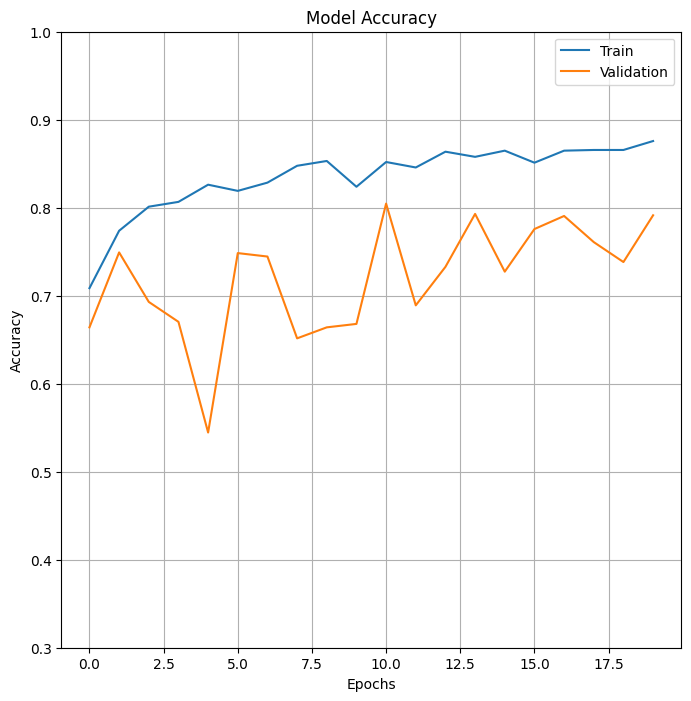

In [ ]:
epochs_range = range(20) #epochs
plt.figure(figsize=(8,8))
plt.plot(epochs_range,history.history['accuracy'], label="Train acc")
plt.plot(epochs_range,history.history['val_accuracy'],label='Valid acc')
plt.axis(ymin=0.3,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

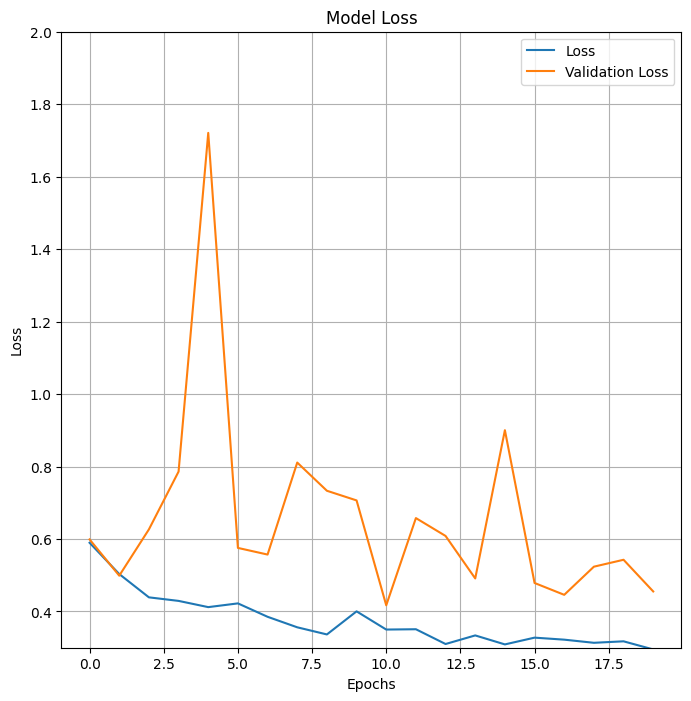

In [ ]:
#Model loss plot
plt.figure(figsize=(8,8))
plt.plot(epochs_range,history.history['loss'], label="Loss")
plt.plot(epochs_range,history.history['val_loss'],label='Valid loss')
plt.axis(ymin=0.3,ymax=2)
plt.grid()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])